# Grey-box identification of heat transfer dynamics

Last update: 01-07-2024

---

The primary goal of this project is to identify convection effects in a grey-box model of heat transfer dynamics (see system description below), based on temperature measurements throughout the rod.

In [1]:
import Pkg
Pkg.activate("..")
Pkg.instantiate()

  Activating project at `~/syndr/Wouter/Onderzoek/Projecten/sioux/sysid-thermal/CCTA2024-BIDconvection`


## System description

A schematic depiction of the setup is shown in the figure below. 

<p><center><img src='../system/system-photo.png'/></center></p>

In short, the setup consists of 3 metal blocks which have been lined up, with resistive nylon pads interposed. The temperature can be measured using thermistors at arbitrary places on the setup; for simplicity we assume that we measure the temperature at a single spot on each block, which we call $\tau_1$, $\tau_2$, and $\tau_3$. The temperatures will evolve due to a number of different factors; we will only consider the influence of conduction, convection, radiation, and the user controlled input heat (band heaters).

By assuming that conduction within blocks is so fast that there are no temperature differences within a block, we may model the system using a [lumped-element model](https://en.wikipedia.org/wiki/Lumped-element_model), governed by the following system of ODEs:

$$\frac{d}{dt}\begin{pmatrix} m_1 c_{p, 1} \tau_1 \\ m_2 c_{p, 2} \tau_2 \\ m_3 c_{p, 3} \tau_3 \end{pmatrix} = 
\underbrace{\begin{pmatrix} -k_{12} & k_{12} & 0 \\ k_{12} & -(k_{12} + k_{23}) & k_{23} \\ 0 & k_{23} & -k_{23} \end{pmatrix} \begin{pmatrix} \tau_1 \\ \tau_2 \\ \tau_3 \end{pmatrix}}_{\textrm{conduction}} + \underbrace{\begin{pmatrix} h(\tau_1, \tau_a, 1, t) \\ h(\tau_2, \tau_a, 2, t) \\ h(\tau_3, \tau_a, 3, t) \end{pmatrix}}_{\textrm{convection}} + \underbrace{\sigma \begin{pmatrix} a_1 \varepsilon_1 (\tau_a^4 - \tau_1^4) \\ a_2 \varepsilon_2 (\tau_a^4 - \tau_2^4) \\ a_3 \varepsilon_3 (\tau_a^4 - \tau_3^4) \end{pmatrix}}_{\textrm{radiation}} + \underbrace{\begin{pmatrix} u_1 \\ u_2 \\ u_3 \end{pmatrix}}_{\textrm{input}}.$$

Convection is notoriously hard to model. A coarse approximation would be Newton's law of cooling (Clercx, 2015; Eq. 8.17), which states that convection is linear in the difference between the temperature of the block and the ambient temperature: $h_a (\tau_a - \tau_i)$. With this linear term, we can take steps similar to the identification of the oscillator in Rogers \& Friis (2022), describing the nonlinear function as the combination of a linear term and a "nonlinear remainder":

$$\underbrace{h(\tau_i, \tau_a, i, t)}_{\text{total convection}} = \underbrace{h_a (\tau_a - \tau_i)}_{\text{linear cooling law}} + \underbrace{r(\tau_i, \tau_a, i, t)}_{\text{nonlinear remainder}} \, ,$$

for some constant $h_a$. Furthermore, the role of radiation can often be neglected. With these simplifications, our governing equations become:

$$\frac{d}{dt}\begin{pmatrix} m_1 c_{p, 1} \tau_1 \\ m_2 c_{p, 2} \tau_2 \\ m_3 c_{p, 3} \tau_3 \end{pmatrix} = 
\begin{pmatrix} -k_{12} & k_{12} & 0 \\ k_{12} & -(k_{12} + k_{23}) & k_{23} \\ 0 & k_{23} & -k_{23} \end{pmatrix} \begin{pmatrix} \tau_1 \\ \tau_2 \\ \tau_3 \end{pmatrix} + h_a \begin{pmatrix} a_1 (\tau_a - \tau_1) \\ a_2 (\tau_a - \tau_2) \\ a_3 (\tau_a - \tau_3) \end{pmatrix} + \begin{pmatrix} r(\tau_1, \tau_a, 1, t) \\ r(\tau_2, \tau_a, 2, t) \\ r(\tau_3, \tau_a, 3, t) \end{pmatrix} + \begin{pmatrix} u_1 \\ u_2 \\ u_3 \end{pmatrix},$$

or, more compactly, 

$$ M \dot{z} = K z + h_a a (\tau_a - z) + r(z,\tau_a) + u$$

where $z = [\tau_1 \, , \ \tau_2 \, , \ \tau_3]$.

In these equations, we can distinguish three types of quantities:
1. Measured/observed quantities: e.g. $\tau_i$, $u_i$. These may vary over time, and are known up to a given accuracy due to measurement noise;

2. Known constants: e.g. $m_i$, $c_{p, i}$, $a$, $\tau_a$. These are fully known, and are constant over time. This is reasonable for quantities such as mass $m$ and surface area $a$ (which can be easily measured) and specific heat capacity $c_p$ (which is a material property which according to the Dulong-Petit Law is roughly constant for metals over a long range of temperatures Carter (2000), Ch. 16) Maybe it is less reasonable for the ambient temperature $\tau_a$ (due to e.g. the setup heating up its surroundings);

3. Unknown constants: e.g. $k_{ij}$, $h_a$. These are not known a priori, because there is no simple physical way to measure or derive their values. For example, the conduction coefficients $k_{ij}$ can vary depending on how tightly the blocks have been put together. In this project, we want to identify these constants using Bayesian inference.

In [2]:
using Revise
using DifferentialEquations
using Distributions
using ForwardDiff
using LaTeXStrings
using LinearAlgebra
using JLD2
using Optim
using Polynomials
using Random
using RxInfer
using Plots; 
default(label="", linewidth=3, margin=15Plots.pt)

include("../util/discretization.jl");
include("../util/heat-input.jl");

## Data simulation

In [3]:
# Time parameters
T = 1000
Δt = 1.0
tsteps = range(1e-3, step=Δt, length=T)

# Constants
true_mcp_1 = 1e3
true_mcp_2 = 1e3
true_mcp_3 = 1e3
true_a_1 = 1.0
true_a_2 = 1.0
true_a_3 = 1.0
true_k12 = 10.
true_k23 = 10.
true_h_a = 2.0
true_τ_a = 21.
true_R   = 1e-3*diagm(ones(3))

# Input heat parameters
true_b = [100.0, 0., 0.];

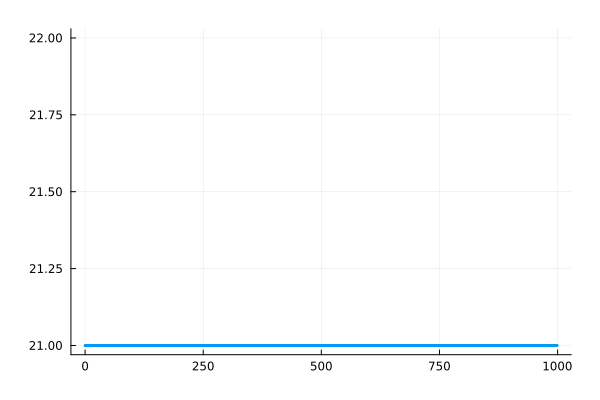

In [4]:
function T_a(t::Float64, t_on::Float64, t_off::Float64)
    return 21 - 5 ./(1+exp(-0.04*(t - t_on))) * exp(-0.05*(t - t_off))./(1+exp(-0.05*(t - t_off)))
end

function T_a(t::Float64)
    return true_τ_a
end

plot(tsteps, T_a.(tsteps))

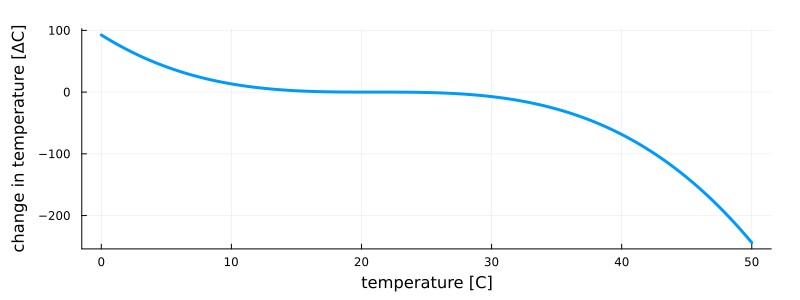

In [5]:
# Nonlinear convection function
r(z,τ_a) = (τ_a - z)^3 ./ 100

τr = range(0., stop=50, step=0.1)
dτr = r.(τr,true_τ_a)

plot(xlabel="temperature [C]", ylabel="change in temperature [ΔC]", size=(800,300))
plot!(τr, dτr)

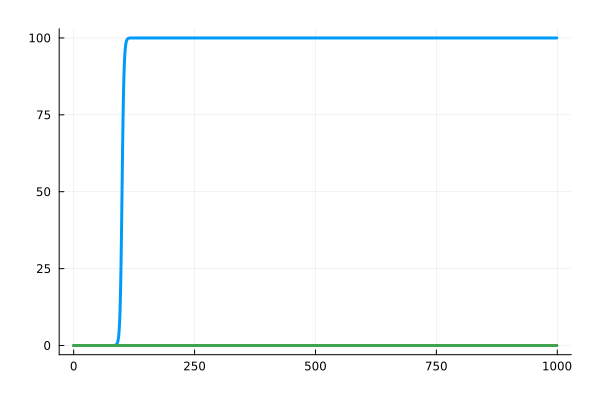

In [6]:
t_onset = 100.
t_offset = 300.
β = 0.5

# Generate functions
u1(t) = u.(t, true_b[1], t_onset, i=1, β=β)
u2(t) = u.(t, true_b[2], t_onset, i=2, β=β)
u3(t) = u.(t, true_b[3], t_onset, i=3, β=β)
  
inputs = hcat([[u1(k); u2(k); u3(k)] for k in tsteps]...)

plot(tsteps, inputs')

In [7]:
function NONLCONV(dz, z, params, t)
    "Lumped-element model with nonlinear convection term"

    # Extract parameters
    mcp_1, mcp_2, mcp_3, a_1, a_2, a_3, k12, k23, h_a = params
    
    # Conduction
    dz[1] = (-k12*z[1] +      k12 *z[2]            ) / mcp_1
    dz[2] = ( k12*z[1] - (k12+k23)*z[2] + k23 *z[3]) / mcp_2
    dz[3] = (                 k23 *z[2] - k23 *z[3]) / mcp_3
    
    # Convection - linear
    dz[1] += h_a * a_1 * (T_a(t) - z[1]) / mcp_1
    dz[2] += h_a * a_2 * (T_a(t) - z[2]) / mcp_2
    dz[3] += h_a * a_3 * (T_a(t) - z[3]) / mcp_3 
    
    # Convection - nonlinear
    dz[1] += r(z[1],T_a(t)) / mcp_1
    dz[2] += r(z[2],T_a(t)) / mcp_2
    dz[3] += r(z[3],T_a(t)) / mcp_3
    
    # Input heat
    dz[1] += u1(t) / mcp_1
    dz[2] += u2(t) / mcp_2
    dz[3] += u3(t) / mcp_3
end

NONLCONV (generic function with 1 method)

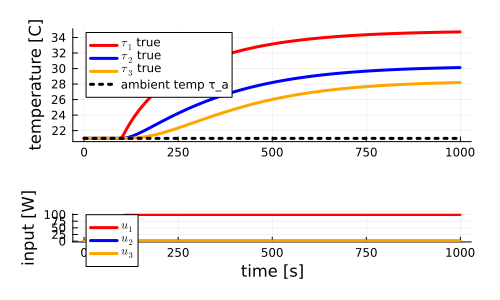

In [8]:
sysparams = [true_mcp_1, 
             true_mcp_2, 
             true_mcp_3, 
             true_a_1, 
             true_a_2, 
             true_a_3,
             true_k12, 
             true_k23, 
             true_h_a]

τ_0 = [21., 21., 21.]

# Solve the system numerically using DifferentialEquations.jl
sys_NONLCONV = ODEProblem(NONLCONV, τ_0, (tsteps[1], tsteps[end]), sysparams)
states = Array(solve(sys_NONLCONV, RK4(); saveat=tsteps, verbose = true))

# Noisy measurements
measurements = zeros(3,T)
for k = 1:T
    measurements[:,k] = states[:,k] + cholesky(true_R).L*randn(3)
end

p101 = plot(xlabel="", ylabel="temperature [C]")
plot!(tsteps, states', linecolors = ["red" "blue" "orange"], labels = [L"$τ_1$ true" L"$τ_2$ true" L"$τ_3$ true"], )
plot!(tsteps, T_a.(tsteps), color="black", linewidth=3, linestyle=:dot, label="ambient temp τ_a")

p102 = plot(xlabel = "time [s]", ylabel = "input [W]")
plot!(tsteps, inputs', linecolors = ["red" "blue" "orange"], labels = [L"$u_1$" L"$u_2$" L"$u_3$"], )

plot(p101, p102, layout=grid(2,1, heights=[0.8, 0.2]), size=(500,300))

In [9]:
output_ = [measurements[:,k] for k in 1:T];
inputs_ = [[true_τ_a; inputs[:,k]] for k in 1:T];

In [10]:
@model function SSM(y,u, A, B, C, Q, R, m0, S0, T)
    
    x_0 ~ MvNormalMeanCovariance(m0, S0)
    x_kmin1 = x_0
    for k = 1:T
        
        x[k] ~ MvNormalMeanCovariance(A*x_kmin1 + B*u[k], Q)
        y[k] ~ MvNormalMeanCovariance(C*x[k], R)
        
        x_kmin1 = x[k]
    end
end

In [11]:
Dx = 3
Du = 4
Dy = 3

M  = [true_mcp_1          0           0;
     0           true_mcp_2           0;
     0                    0  true_mcp_3]
K  = [-true_k12       true_k12                0;
       true_k12  -(true_k12+true_k23)  true_k23;
              0       true_k23        -true_k23]
An = [true_a_1, true_a_2, true_a_3]

F  = inv(M)*(K - true_h_a*diagm(An))
G  = inv(M)*[true_h_a*An diagm(ones(Dx))]

λ_star = 1000.
γ_star = 50.

A  = exp(F*Δt)
B  = G*Δt
C  = diagm(ones(Dy))
Q  = 1e-12*diagm(ones(Dx))
R  = true_R*diagm(ones(Dy))

m0 = τ_0
S0 = diagm(ones(Dx))

results = infer(
    model       = SSM(A=A, B=B, C=C, Q=Q, R=R, m0=m0, S0=S0, T=T),
    data        = (y = output_, u = inputs_),
    options     = (limit_stack_depth = 100,),
    free_energy = true,
)

Inference results:
  Posteriors       | available for (x_0, x)
  Free Energy:     | Real[5.28424e6]


In [12]:
qx = results.posteriors[:x]
fitx_v = cat( var.(qx)..., dims=2)
fitx_m = cat(mean.(qx)..., dims=2)

3×1000 Matrix{Float64}:
 19.6008  19.6041  19.6074  19.6107  …  39.4608  39.4667  39.4727  39.4786
 19.6512  19.6539  19.6566  19.6593     33.6816  33.6875  33.6934  33.6993
 19.699   19.7011  19.7033  19.7055     31.0776  31.0835  31.0894  31.0953

In [13]:
SMSE_GPSSM = mean((fitx_m[1:3,:] - states).^2)
println("MSE states and fit: $SMSE_GPSSM")

MSE states and fit: 3.523401922037596


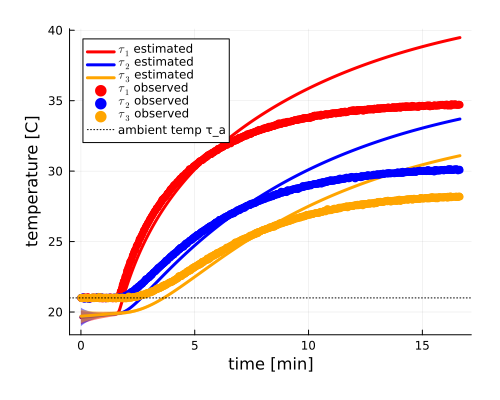

In [14]:
plot(tsteps ./ 60,
     fitx_m';
     ribbon=100sqrt.(fitx_v)',
     legend = true, 
     linecolors = ["red" "blue" "orange"], 
     fillcolors = ["red" "blue" "orange"], 
     labels = [L"$τ_1$ estimated" L"$τ_2$ estimated" L"$τ_3$ estimated"],
     xlabel = "time [min]", 
     ylabel = "temperature [C]",
     size=(500,400)
)
scatter!(tsteps ./ 60, measurements', markerstrokewidth=0, markercolors = ["red" "blue" "orange"], labels = [L"$τ_1$ observed" L"$τ_2$ observed" L"$τ_3$ observed"])
hline!([true_τ_a], color="black", linewidth=1, linestyle=:dot, label="ambient temp τ_a")


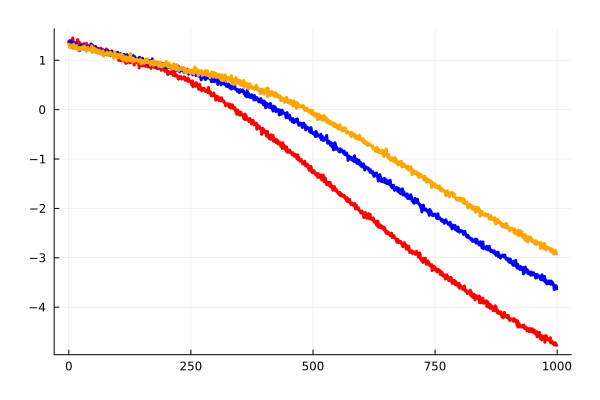

In [15]:
# Post-measurement residuals
residuals = measurements - C*fitx_m

plot(tsteps, residuals[1,:], color="red")
plot!(tsteps, residuals[2,:], color="blue")
plot!(tsteps, residuals[3,:], color="orange")

### Fit GP to residuals

In [16]:
deg = 3

f1_pol3 = Polynomials.fit(fitx_m[1,:], residuals[1,:], deg)
f2_pol3 = Polynomials.fit(fitx_m[2,:], residuals[2,:], deg)
f3_pol3 = Polynomials.fit(fitx_m[3,:], residuals[3,:], deg)

Polynomial(34.683188324034404 - 4.344220760681199*x + 0.19167279695700318*x^2 - 0.002922607218597893*x^3)

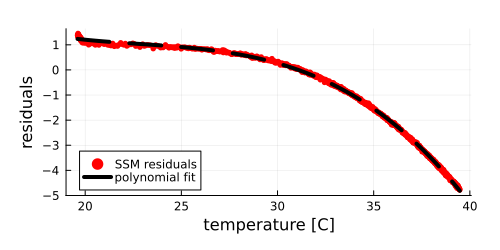

In [17]:
plot(xlabel="temperature [C]",
     ylabel="residuals",
     size=(500,250),
     legend=:bottomleft,
     )
scatter!(fitx_m[1,:], residuals[1,:], alpha=1., markerstrokewidth=0, markersize=3, label="SSM residuals", color="red")
plot!(sort(fitx_m[1,:]), x -> f1_pol3(x), linewidth=4, color="black", linestyle=:dash, label="polynomial fit")

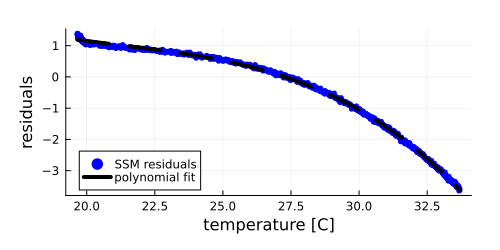

In [18]:
plot(xlabel="temperature [C]",
     ylabel="residuals",
     size=(500,250),
     legend=:bottomleft,
     )
scatter!(fitx_m[2,:], residuals[2,:], alpha=1., markerstrokewidth=0, markersize=3, label="SSM residuals", color="blue")
plot!(sort(fitx_m[2,:]), x -> f2_pol3(x), linewidth=4, color="black", linestyle=:dash, label="polynomial fit")

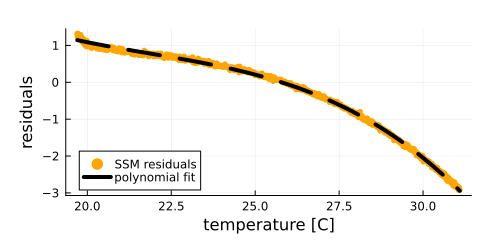

In [19]:
plot(xlabel="temperature [C]",
     ylabel="residuals",
     size=(500,250),
     legend=:bottomleft,
     )
scatter!(fitx_m[3,:], residuals[3,:], alpha=1., markerstrokewidth=0, markersize=3, label="SSM residuals", color="orange")
plot!(sort(fitx_m[3,:]), x -> f3_pol3(x), linewidth=4, color="black", linestyle=:dash, label="polynomial fit")

## Model validation

### Simulation with true function to generate validation data

In [20]:
N_val = 1000
tsteps_val = range(0.0, step=Δt, length=N_val)

t_onset_val = 120.
t_offset_val = 600.
β = 0.5

# Generate functions
u1_val(t) = u.(t, b=true_b[1], t_on=t_onset_val, t_off=t_offset_val, i=1, β1=β)
u2_val(t) = u.(t, b=true_b[2], t_on=t_onset_val, t_off=t_offset_val, i=2, β1=β)
u3_val(t) = u.(t, b=true_b[3], t_on=t_onset_val, t_off=t_offset_val, i=3, β1=β)

inputs_val = hcat([[u1_val(k); u2_val(k); u3_val(k)] for k in tsteps_val]...)

3×1000 Matrix{Float64}:
 8.75651e-25  1.4437e-24  2.38027e-24  3.9244e-24  …  7.24967e-68  4.8596e-68
 0.0          0.0         0.0          0.0            0.0          0.0
 0.0          0.0         0.0          0.0            0.0          0.0

In [21]:
function NONLCONV_val(dz, z, params, t)
    "Lumped-element model with nonlinear convection term"

    # Extract parameters
    mcp_1, mcp_2, mcp_3, a_1, a_2, a_3, τ_a, k12, k23, h_a = params
    
    # Conduction
    dz[1] = (-k12*z[1] +      k12 *z[2]            ) / mcp_1
    dz[2] = ( k12*z[1] - (k12+k23)*z[2] + k23 *z[3]) / mcp_2
    dz[3] = (                 k23 *z[2] - k23 *z[3]) / mcp_3
    
    # Convection - linear
    dz[1] += h_a * a_1 * (τ_a - z[1]) / mcp_1
    dz[2] += h_a * a_2 * (τ_a - z[2]) / mcp_2
    dz[3] += h_a * a_3 * (τ_a - z[3]) / mcp_3
    
    # Convection - nonlinear
    dz[1] += r(z[1],τ_a) ./ mcp_1
    dz[2] += r(z[2],τ_a) ./ mcp_2
    dz[3] += r(z[3],τ_a) ./ mcp_3
    
    # Input heat
    dz[1] += u1_val(t) / mcp_1
    dz[2] += u2_val(t) / mcp_2
    dz[3] += u3_val(t) / mcp_3
end

NONLCONV_val (generic function with 1 method)

In [22]:
sysparams = [true_mcp_1, 
             true_mcp_2, 
             true_mcp_3, 
             true_a_1, 
             true_a_2, 
             true_a_3, 
             true_τ_a, 
             true_k12, 
             true_k23, 
             true_h_a]

τ0_val = [25., 25., 25.]
sys_NONLCONV = ODEProblem(NONLCONV_val, τ0_val, (tsteps_val[1], tsteps_val[end]), sysparams)
states_val = Array(solve(sys_NONLCONV, RK4(); saveat=tsteps_val, verbose = true))

measurements_val = states_val + cholesky(true_R).L*randn(size(states_val))

3×1000 Matrix{Float64}:
 24.9928  24.9905  25.0237  24.9523  …  24.647   24.658   24.6368  24.5856
 25.0271  25.0703  24.9682  25.0146     24.6076  24.5885  24.606   24.5974
 25.0207  24.9894  24.9361  24.985      24.5667  24.5908  24.6552  24.5476

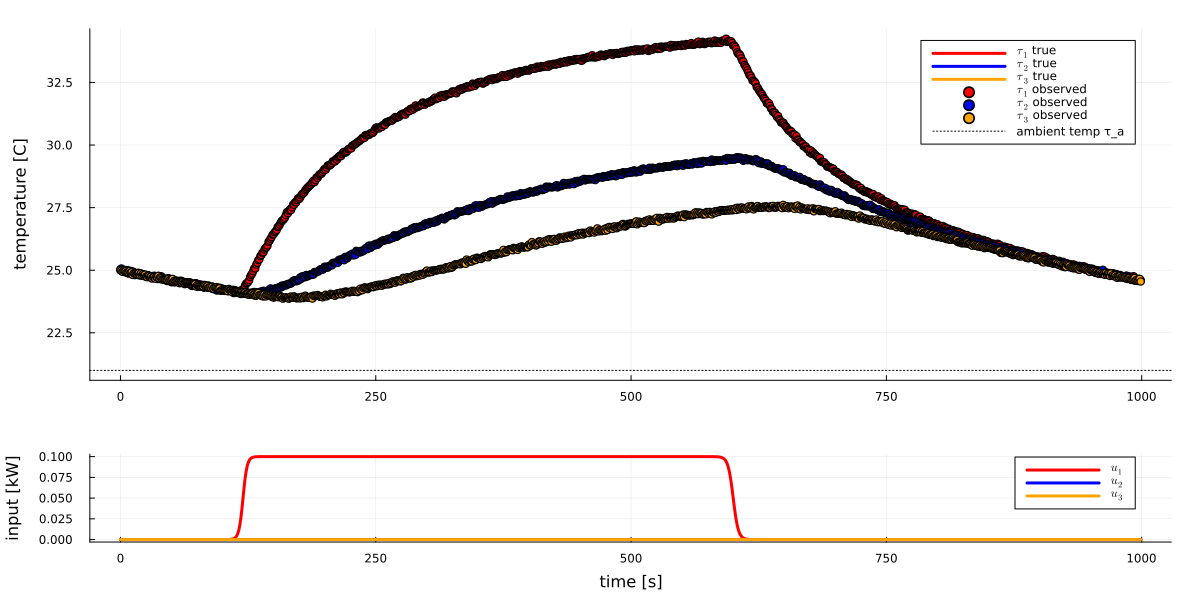

In [23]:
p101 = plot(xlabel="", ylabel="temperature [C]")
plot!(tsteps_val, states_val', linecolors = ["red" "blue" "orange"], labels = [L"$τ_1$ true" L"$τ_2$ true" L"$τ_3$ true"], )
scatter!(tsteps_val, measurements_val', markercolors = ["red" "blue" "orange"], labels = [L"$τ_1$ observed" L"$τ_2$ observed" L"$τ_3$ observed"])
hline!([true_τ_a], color="black", linewidth=1, linestyle=:dot, label="ambient temp τ_a")

p102 = plot(xlabel = "time [s]", ylabel = "input [kW]")
plot!(tsteps_val, inputs_val' ./ 1000, linecolors = ["red" "blue" "orange"], labels = [L"$u_1$" L"$u_2$" L"$u_3$"], )

plot(p101, p102, layout=grid(2,1, heights=[0.8, 0.2]), size=(1200,600))

### Simulation by identified model

In [31]:
function NONLCONV_idsim(dz, z, params, t)
    "Lumped-element model with nonlinear convection term"

    # Extract parameters
    mcp_1, mcp_2, mcp_3, a_1, a_2, a_3, τ_a, k12, k23, h_a = params
    
    # Conduction
    dz[1] = (-k12*z[1] +      k12 *z[2]            ) / mcp_1
    dz[2] = ( k12*z[1] - (k12+k23)*z[2] + k23 *z[3]) / mcp_2
    dz[3] = (                 k23 *z[2] - k23 *z[3]) / mcp_3
    
    # Convection - linear
    dz[1] += h_a * a_1 * (τ_a - z[1]) / mcp_1
    dz[2] += h_a * a_2 * (τ_a - z[2]) / mcp_2
    dz[3] += h_a * a_3 * (τ_a - z[3]) / mcp_3
    
    # Convection - nonlinear
    dz[1] += f1_pol3(z[1]) / mcp_1
    dz[2] += f2_pol3(z[2]) / mcp_2
    dz[3] += f3_pol3(z[3]) / mcp_3
    
    # Input heat
    dz[1] += u1_val(t) / mcp_1
    dz[2] += u2_val(t) / mcp_2
    dz[3] += u3_val(t) / mcp_3
end

idNONLCONV = ODEProblem(NONLCONV_idsim, τ0_val, (tsteps_val[1], tsteps_val[end]), sysparams)
sim_states = Array(solve(idNONLCONV, RK4(); saveat=tsteps_val, verbose = true))

3×1000 Matrix{Float64}:
 25.0  24.9929  24.9858  24.9788  …  26.1203  26.1101  26.0999  26.0898
 25.0  24.9925  24.9851  24.9777     26.0394  26.0297  26.0201  26.0104
 25.0  24.9922  24.9845  24.9767     25.9637  25.9545  25.9453  25.9361

### Compare true and identified 

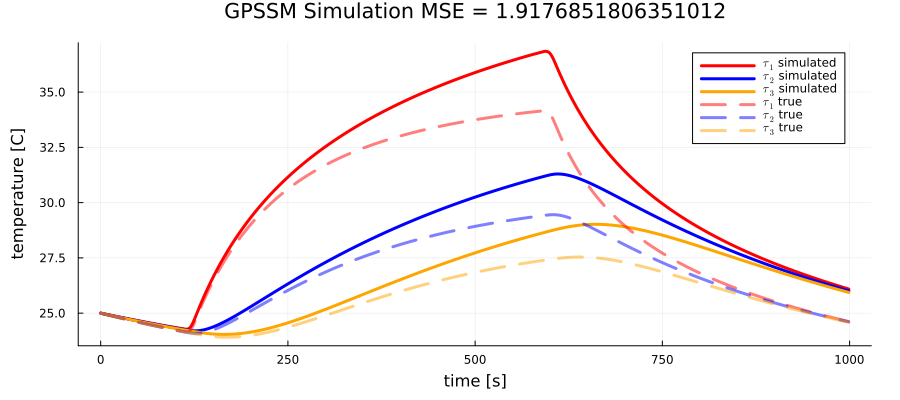

In [32]:
SMSE_GPSSM = mean((sim_states - states_val).^2)

plot(tsteps_val,
     sim_states';
     legend = true, 
     title = "GPSSM Simulation MSE = $SMSE_GPSSM",
     linecolors = ["red" "blue" "orange"], 
     fillcolors = ["red" "blue" "orange"], 
     labels = [L"$τ_1$ simulated" L"$τ_2$ simulated" L"$τ_3$ simulated"],
     xlabel = "time [s]", 
     ylabel = "temperature [C]",
     size=(900,400)
)
plot!(tsteps_val, 
      transpose(states_val), 
      alpha = 0.5,
      linecolors = ["red" "blue" "orange"], 
      linestyle = :dash,
      labels = [L"$τ_1$ true" L"$τ_2$ true" L"$τ_3$ true"],
)


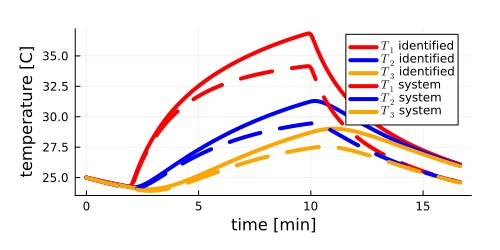

In [33]:
plot(tsteps_val ./ 60,
     sim_states';
     legend = true, 
     linewidth=4,
     linecolors = ["red" "blue" "orange"], 
     fillcolors = ["red" "blue" "orange"], 
     labels = [L"$T_1$ identified" L"$T_2$ identified" L"$T_3$ identified"],
     xlabel = "time [min]", 
     ylabel = "temperature [C]",
     size=(500,250)
)
plot!(tsteps_val ./ 60, 
      transpose(states_val), 
      linewidth=4,
      alpha = 1.,
      linecolors = ["red" "blue" "orange"], 
      linestyle = :dash,
      labels = [L"$T_1$ system" L"$T_2$ system" L"$T_3$ system"],
)


In [34]:
jldsave("results/SSM+GPr.jld2"; true_mcp_1, true_mcp_2, true_mcp_3, true_τ_a, tsteps, Δt, fitx_m, fitx_v, states, measurements, inputs, f1_pol3, f2_pol3, f3_pol3, λ_star, γ_star, residuals, tsteps_val, sim_states, states_val)